In [1]:
cd ..

/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/rima/lightning-hydra-template


In [2]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from src.models.components.models import BaselineUNet, FastSmoothSENormDeepUNet_supervision_skip_no_drop
from src.models.rima_module import RimaModule
from src.datamodules.components.rima_dataset import RimaDataset
from src.models.components.metrics import dice
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import KFold
from src.models.components.new_nets.legonet import LegoNet
from src.models.components.new_nets.swin_unetr import SwinUNETR
from src.models.components.new_nets.unest.unest import UNesT
from src.models.components.new_nets.uxnet import UXNET
from monai.networks.nets import UNETR, SegResNet, UNet


In [3]:
def read_nifti(path):
    """Read a NIfTI image. Return a SimpleITK Image."""
    nifti = sitk.ReadImage(str(path))
    return nifti


def write_nifti(sitk_img, path):
    """Save a SimpleITK Image to disk in NRRD format."""
    writer = sitk.ImageFileWriter()
    writer.SetImageIO("NrrdImageIO")
    writer.SetFileName(str(path))
    writer.Execute(sitk_img)



In [218]:
data_path = pathlib.Path('/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/training/ctca/baseline_ctca/')

# chkpt_path = 'logs/experiments/runs/default/2023-01-17_07-46-40/checkpoints/epoch_080.ckpt'
# chkpt_path = 'logs/experiments/runs/default/2022-12-30_05-01-37/checkpoints/epoch_052.ckpt'
# chkpt_path = 'logs/experiments/runs/default/2022-12-30_05-02-15/checkpoints/epoch_061.ckpt'
# chkpt_path = 'logs/experiments/runs/default/2022-12-30_05-02-45/checkpoints/epoch_042.ckpt'
chkpt_path = 'logs/experiments/runs/default/2022-12-30_05-03-17/checkpoints/epoch_027.ckpt'

fold = 5

In [219]:
from torch.utils.data import DataLoader
from src.datamodules.augmentations import *

trans_pred = Compose([
                    NormalizeIntensity(),
                    ToTensor(), 
                    Resizing(z=96,x=96,y=96),
                    ])



dataset = RimaDataset(data_path, transforms=trans_pred)

full_indices = range(len(dataset))

kf = KFold(n_splits=5, shuffle=True, random_state=786)

train_idx = {}
test_idx = {}

key = 1
for i,j in kf.split(full_indices):
    train_idx[key] = i
    test_idx[key] = j

    key += 1

train_dataset, val_dataset = Subset(dataset, train_idx[fold]), Subset(dataset, test_idx[fold])
print(len(dataset), len(train_dataset), len(val_dataset))


pred_loader = DataLoader(
            dataset=val_dataset,
            batch_size=1,
            num_workers=8,
            pin_memory=True,
            shuffle=False,
        )

155 124 31


In [220]:
# data_pred = next(iter(pred_loader))
# print(data_pred['id'])

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [222]:
model = LegoNet(
                in_channels=1,
                out_channels=1,
                depths=[2, 2, 2, 2],
                feature_size=[24,48,96,192], #[48, 96, 192, 384], 
                drop_path_rate=0,
                layer_scale_init_value=1e-6,
                spatial_dims=3,
                hidden_size=768,
                return_logits = False
            )

# model = SegResNet(in_channels=1,
#                 out_channels=1,
#                 )

# model = SwinUNETR(
#                                     img_size=(96,96,96),
#                                     in_channels=1,
#                                     out_channels=1,
#                                     feature_size=24)
model = model.to(device)


In [223]:
checkpoint = torch.load(chkpt_path)
state_dict = checkpoint['state_dict']
for key in list(state_dict):
    state_dict[key.replace("model.", "")] = state_dict.pop(key)

model.load_state_dict(state_dict)
model.eval()

LegoNet(
  (encoder): LegoNetEncoderv2(
    (downsample_layers): ModuleList()
    (stem): Sequential(
      (0): RESseNormConv3d(
        (conv1): FastSmoothSeNormConv3d(
          (conv): Conv3d(1, 24, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
          (norm): FastSmoothSENorm(
            (norm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (gamma): SEWeights(
              (conv1): Conv3d(24, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1))
              (conv2): Conv3d(12, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            )
            (beta): SEWeights(
              (conv1): Conv3d(24, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1))
              (conv2): Conv3d(12, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            )
          )
        )
        (res_conv): FastSmoothSeNormConv3d(
          (conv): Conv3d(1, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (norm): FastSmoothSENorm(
            (n

In [191]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['fold'] = []
metric_dictionary['resize_metric'] = []

In [224]:
with torch.no_grad():
    for sample in pred_loader:

        input, target = sample['input'].to(device), sample['target'].to(device)

        output = model(input)

        y_pred = torch.where(output>0.5, 1, 0).float()

        metric_value_rs = dice(y_pred.detach(), target.detach())

        metric_dictionary['id'].append(sample['id'][0])
        metric_dictionary['fold'].append(fold)
        metric_dictionary['resize_metric'].append(metric_value_rs.item())
        
        print(f"id: {sample['id'][0]}, metric_rs: {metric_value_rs}")

id: R208, metric_rs: 0.7437673211097717
id: F0599-2, metric_rs: 0.8661728501319885
id: F0646-2, metric_rs: 0.7411167621612549
id: R171, metric_rs: 0.7347242832183838
id: R230, metric_rs: 0.7772194147109985
id: R175, metric_rs: 0.7591036558151245
id: F0486-1, metric_rs: 0.8104347586631775
id: F0308-2, metric_rs: 0.8368663787841797
id: R163, metric_rs: 0.6896551847457886
id: F0637-1, metric_rs: 0.6119951009750366
id: R160, metric_rs: 0.7521865963935852
id: 233-2, metric_rs: 0.7185103893280029
id: R200, metric_rs: 0.8262839913368225
id: 226-1, metric_rs: 0.7711686491966248
id: F0235-1, metric_rs: 0.5541516542434692
id: F0244-2, metric_rs: 0.7515974640846252
id: R240, metric_rs: 0.8529638051986694
id: F0068-1, metric_rs: 0.7454965114593506
id: 234-1, metric_rs: 0.7161125540733337
id: R220, metric_rs: 0.7868362069129944
id: F0410-1, metric_rs: 0.907508134841919
id: 230-2, metric_rs: 0.7602179646492004
id: R214, metric_rs: 0.7767584323883057
id: 212-2, metric_rs: 0.6294865012168884
id: R159,

In [225]:
print("Original Mean:", np.mean(sorted(metric_dictionary['resize_metric'])))
print("Original SD:", np.std(sorted(metric_dictionary['resize_metric'])))

Original Mean: 0.752101694960748
Original SD: 0.1067223880413204


In [226]:
metrid_df = pd.DataFrame.from_dict(metric_dictionary)
metrid_df.to_csv(f"files/legonet_v2.csv", index=False)

#### Load the csvs and put them together

In [4]:
lego_df = pd.read_csv('files/legonet.csv')
segresnet_df = pd.read_csv('files/segresnet.csv')
swinunetr_df = pd.read_csv('files/swinunetr.csv')

In [5]:
lego_df.rename(columns={'resize_metric': 'lego_dsc'}, inplace=True)
segresnet_df.rename(columns={'resize_metric': 'segresnet_dsc'}, inplace=True)
swinunetr_df.rename(columns={'resize_metric': 'swinunetr_dsc'}, inplace=True)

In [6]:
merged_df = pd.merge(lego_df, segresnet_df, on=['id', 'fold'], how='inner')
merged_df = pd.merge(merged_df, swinunetr_df, on=['id', 'fold'], how='inner')


In [7]:
print("LEGO Mean:", np.mean(sorted(merged_df['lego_dsc'])))
print("LEGO SD:", np.std(sorted(merged_df['lego_dsc'])))
print("SegResNet Mean:", np.mean(sorted(merged_df['segresnet_dsc'])))
print("SegResNet SD:", np.std(sorted(merged_df['segresnet_dsc'])))
print("SwinUNETR Mean:", np.mean(sorted(merged_df['swinunetr_dsc'])))
print("SwinUNETR SD:", np.std(sorted(merged_df['swinunetr_dsc'])))

LEGO Mean: 0.7454574279246792
LEGO SD: 0.10642312367689837
SegResNet Mean: 0.7325617296080436
SegResNet SD: 0.11324072721329968
SwinUNETR Mean: 0.7145321665421849
SwinUNETR SD: 0.11330527830630063


In [8]:
from scipy.stats import ttest_ind

# Extract the dsc values from each dataframe
lego_dsc = merged_df['lego_dsc']
segresnet_dsc = merged_df['segresnet_dsc']
swinunetr_dsc = merged_df['swinunetr_dsc']

#### This is not non-parametric, with assumption of normality, equal variance, and independence. So, we cannot use it on our data.
# Perform two-sample t-tests
# lego_vs_segresnet = ttest_ind(lego_dsc, segresnet_dsc)
# lego_vs_swinunetr = ttest_ind(lego_dsc, swinunetr_dsc)

# # Print the results
# print("LEGO vs. SegResNet: p-value =", lego_vs_segresnet.pvalue)
# print("LEGO vs. SwinUNETR: p-value =", lego_vs_swinunetr.pvalue)

In [9]:
from scipy.stats import wilcoxon

# Perform two-tailed Wilcoxon signed-rank test
result = wilcoxon(lego_dsc, segresnet_dsc)

# Print the p-value
print("Two-tailed p-value =", result.pvalue)

Two-tailed p-value = 0.0006364445757492369


In [10]:
# Perform two-tailed Wilcoxon signed-rank test
result = wilcoxon(lego_dsc, swinunetr_dsc)

# Print the p-value
print("Two-tailed p-value =", result.pvalue)

Two-tailed p-value = 8.528791442226871e-10


In [11]:
from scipy.stats import wilcoxon

# Perform one-tailed Wilcoxon signed-rank test in the positive direction
result = wilcoxon(lego_dsc, segresnet_dsc, alternative='greater')

# Calculate the one-tailed p-value
p_value = result.pvalue / 2

# Print the one-tailed p-value
print("One-tailed p-value =", p_value)

One-tailed p-value = 0.00015911114393730923


In [12]:
# Perform one-tailed Wilcoxon signed-rank test in the positive direction
result = wilcoxon(lego_dsc, swinunetr_dsc, alternative='greater')

# Calculate the one-tailed p-value
p_value = result.pvalue / 2

# Print the one-tailed p-value
print("One-tailed p-value =", p_value)

One-tailed p-value = 2.1321978605567177e-10


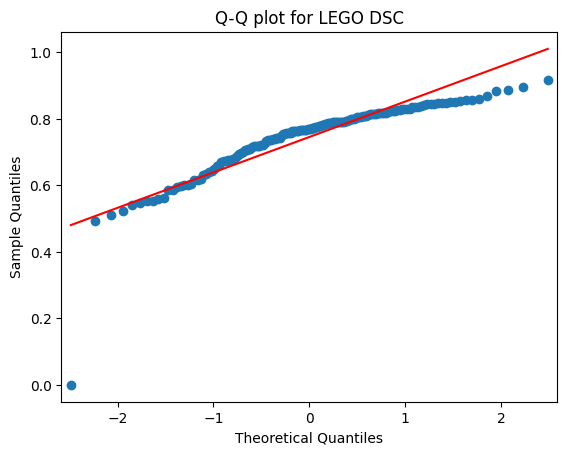

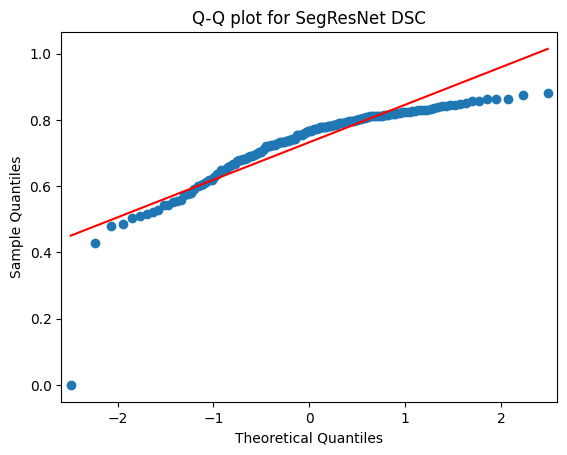

In [13]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

# Create Q-Q plots
qqplot(lego_dsc, line='s')
plt.title('Q-Q plot for LEGO DSC')
plt.show()

qqplot(segresnet_dsc, line='s')
plt.title('Q-Q plot for SegResNet DSC')
plt.show()

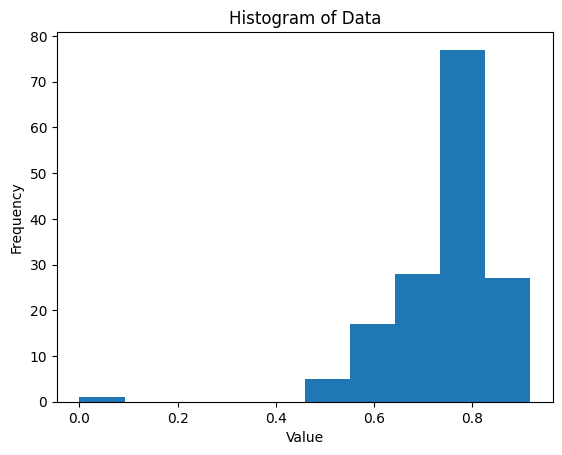

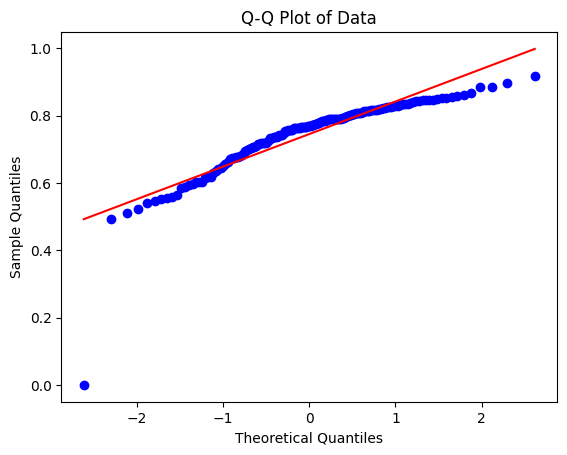

In [27]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a histogram
plt.hist(lego_dsc, bins=10)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Create a Q-Q plot
stats.probplot(lego_dsc, dist='norm', plot=plt)
plt.title('Q-Q Plot of Data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

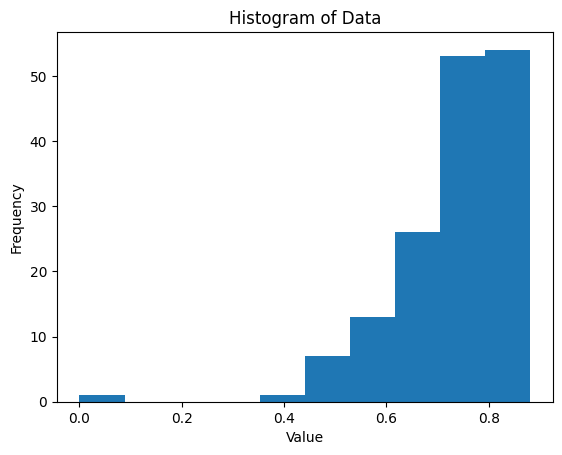

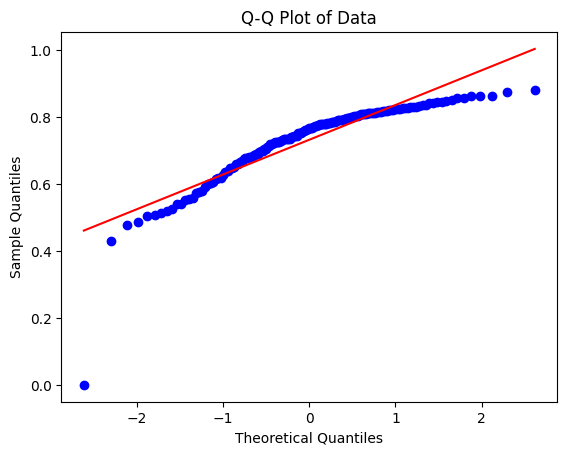

In [28]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a histogram
plt.hist(segresnet_dsc, bins=10)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Create a Q-Q plot
stats.probplot(segresnet_dsc, dist='norm', plot=plt)
plt.title('Q-Q Plot of Data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [14]:
from scipy.stats import levene

# Perform Levene's test
result = levene(lego_dsc, segresnet_dsc)

# Print the p-value
print("p-value =", result.pvalue)

p-value = 0.43787646737946795


In [15]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
result = shapiro(segresnet_dsc)

# Print the p-value
print("p-value =", result.pvalue)

p-value = 2.4532554807055185e-12


In [18]:
from scipy.stats import kstest
from scipy.stats import norm

# Generate a sample from a normal distribution
sample = norm.rvs(size=100)

# Perform Kolmogorov-Smirnov test
result = kstest(lego_dsc, 'norm')

# Print the p-value
print("p-value =", result.pvalue)

p-value = 2.4968083933496957e-72


In [19]:
from scipy.stats import f_oneway

# Perform one-way ANOVA
result = f_oneway(lego_dsc, segresnet_dsc, swinunetr_dsc)

# Print the p-value
print("p-value =", result.pvalue)

p-value = 0.05006725703235003


In [22]:
from scipy.stats import ttest_ind

# Perform two-sample t-test
result = ttest_ind(lego_dsc, segresnet_dsc, equal_var=False)

# Print the p-value
print("p-value =", result.pvalue)

p-value = 0.30391536827091675


In [23]:
from scipy.stats import ttest_rel

# Perform paired t-test
result = ttest_rel(lego_dsc, segresnet_dsc)

# Print the p-value
print("p-value =", result.pvalue)

p-value = 0.004059132438136386


In [29]:
from scipy.stats import ks_2samp

# Perform Kolmogorov-Smirnov test
result = ks_2samp(lego_df['lego_dsc'], segresnet_df['segresnet_dsc'])

# Print the p-value
print("p-value =", result.pvalue)

p-value = 0.7434362541847752


#### Generate the Volumes table and get MAE values

In [1]:
import pandas as pd

In [2]:
# read csv
df_vol_1 = pd.read_csv('/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/rima/lightning-hydra-template/files/volumes_1.csv')
df_vol_2 = pd.read_csv('/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/rima/lightning-hydra-template/files/volumes_2.csv')
df_vol_3 = pd.read_csv('/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/rima/lightning-hydra-template/files/volumes_3.csv')


In [3]:
len(df_vol_3), len(df_vol_2), len(df_vol_1)

(54, 41, 39)

In [4]:
df_vol_1.head()

,cheng,model,dsc
0,13768.0,15928.0,0.923626
1,11204.0,12067.0,0.962915
2,12825.0,12944.0,0.980558
3,9045.0,11153.0,0.877909
4,11869.0,11628.0,0.965230


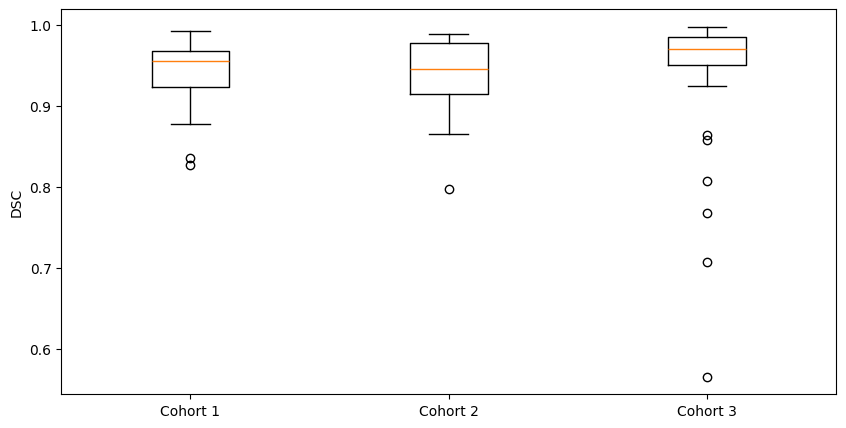

In [13]:
import matplotlib.pyplot as plt

# plot the three df_vol_{i} in the box plots within the same figure along with each values
plt.figure(figsize=(10, 5))
plt.boxplot([df_vol_1['dsc'], df_vol_2['dsc'], df_vol_3['dsc']], labels=['Cohort 1', 'Cohort 2', 'Cohort 3'])
plt.ylabel('DSC')
plt.title('')
plt.show()


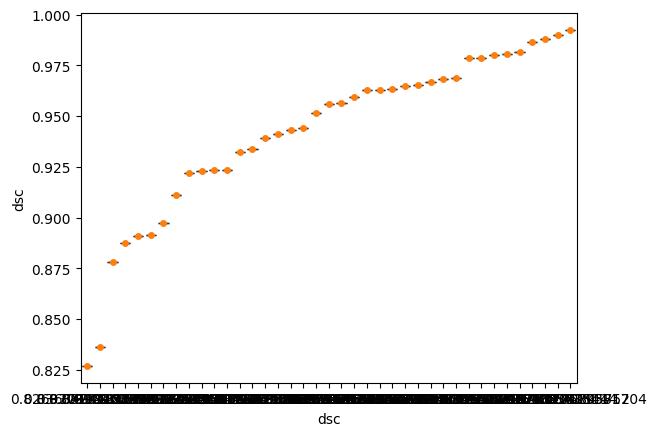

In [ ]:
# importing library 
import seaborn as sns 
import matplotlib.pyplot as plt 
# loading seaborn dataset tips 
# tdata = sns.load_dataset('tips') 
  
# creating boxplot 
sns.boxplot(x='dsc', y='dsc', data=df_vol_1) 
  
# adding data points 
sns.stripplot(x='dsc', y='dsc', data=df_vol_1) 
# display plot 
plt.show() 


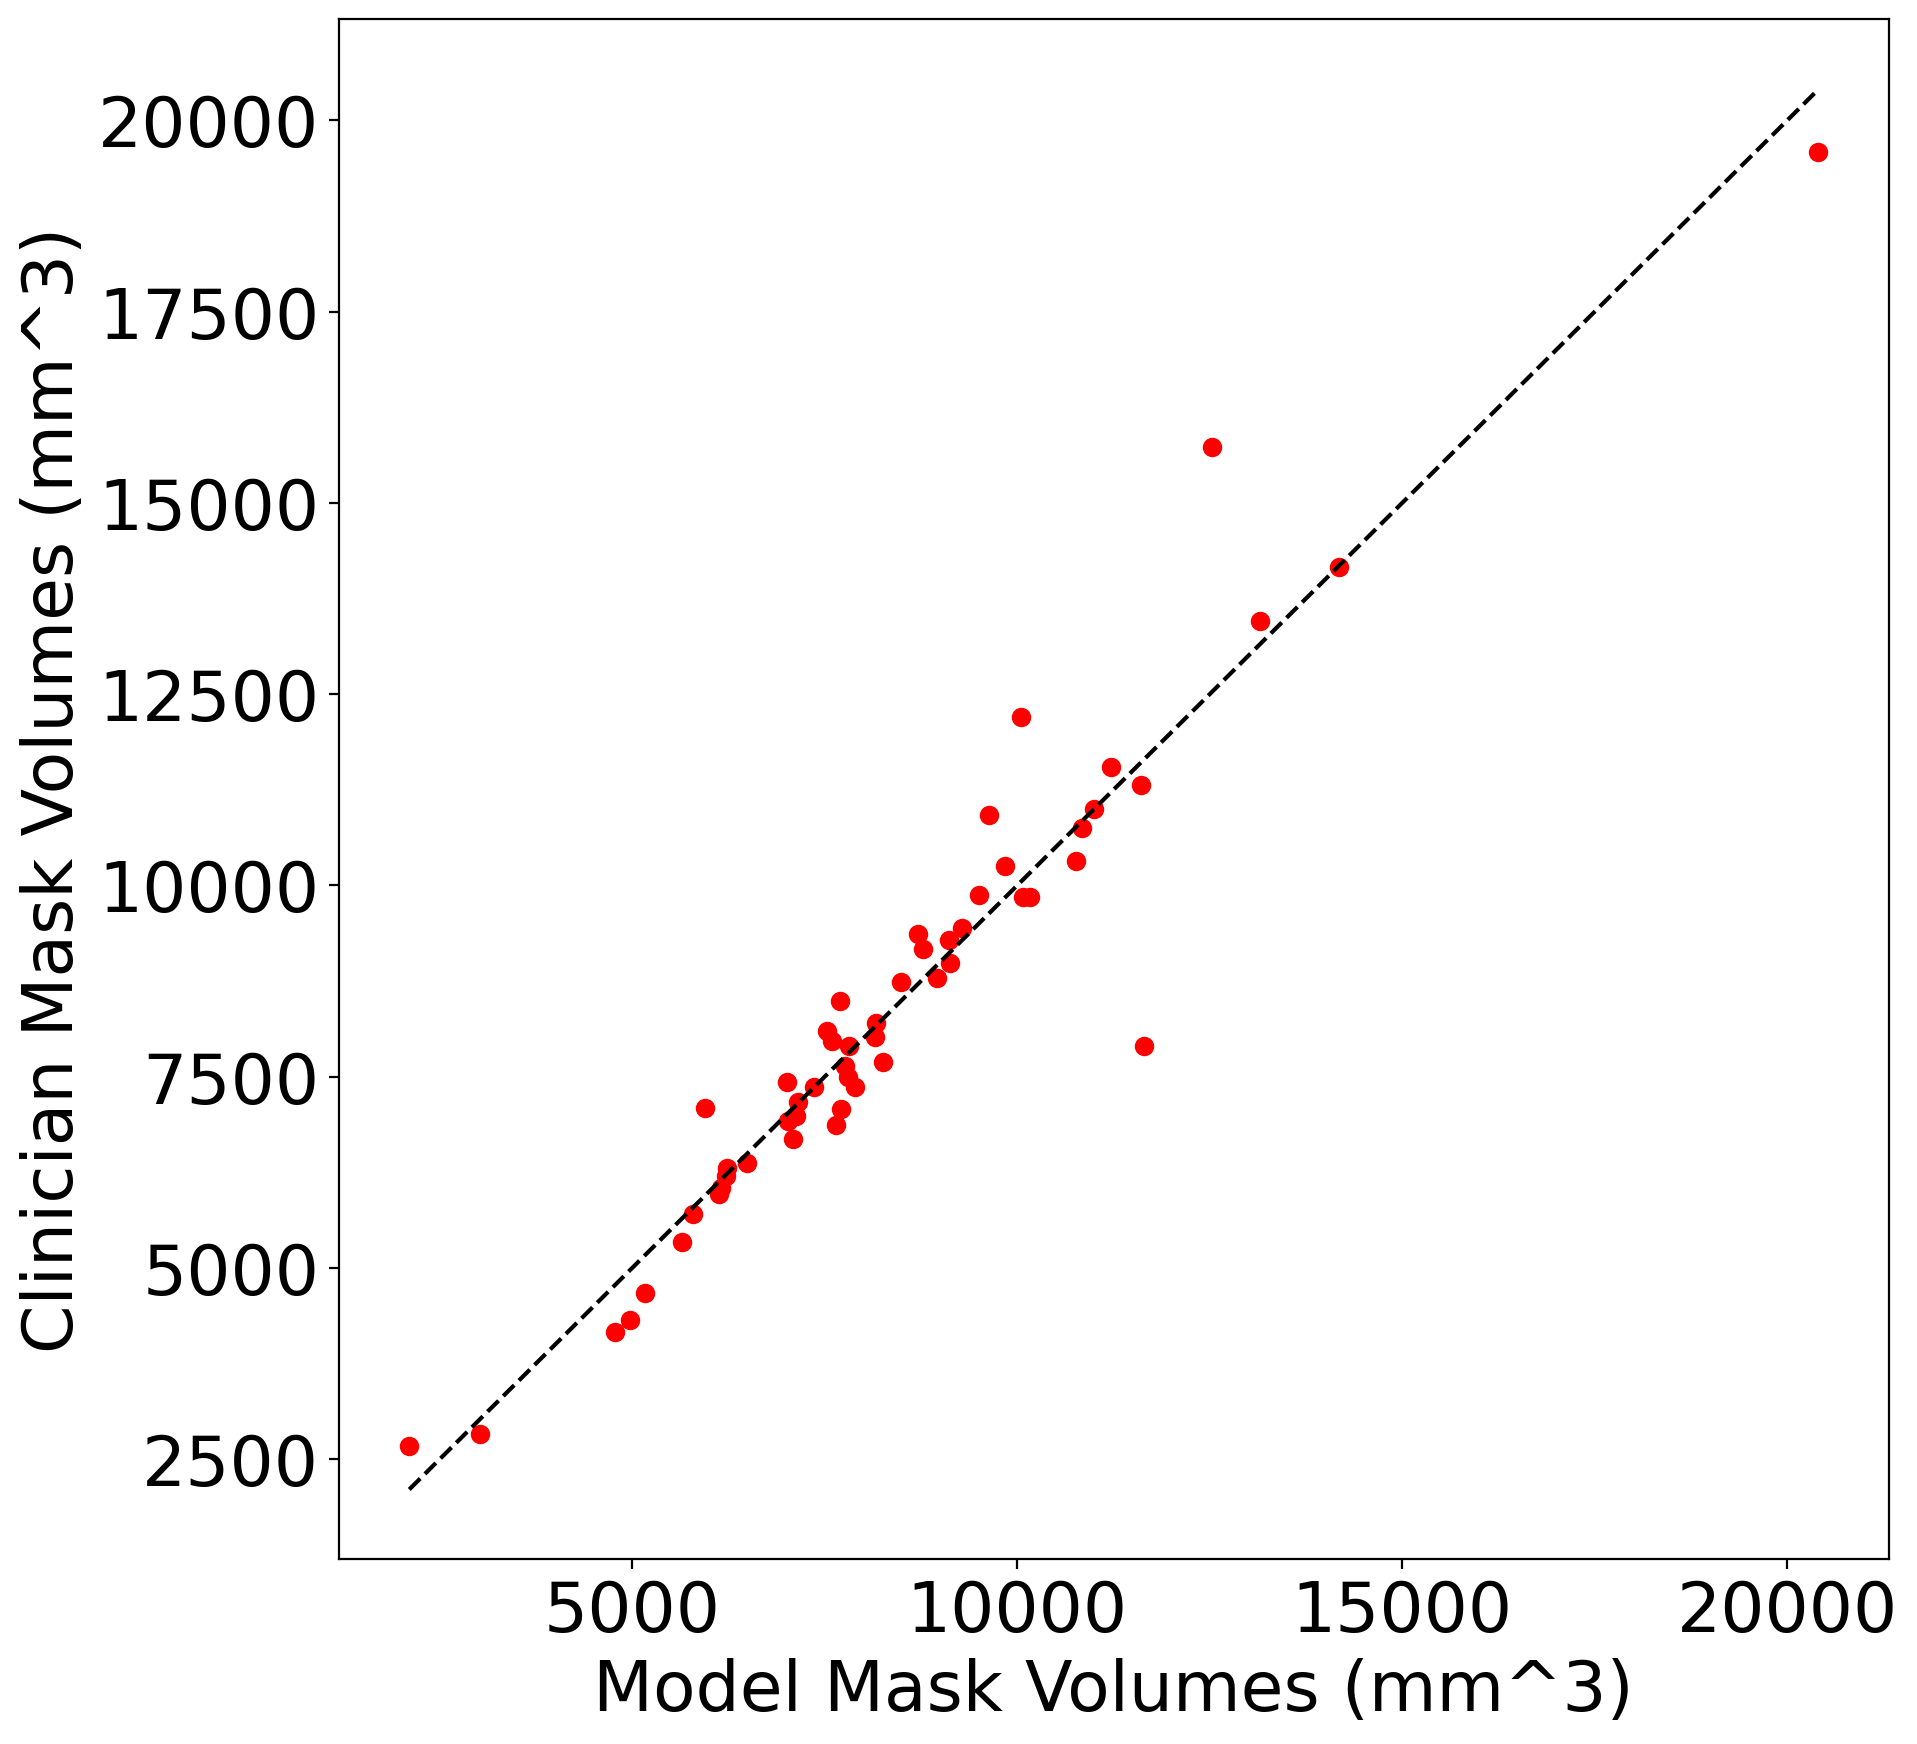

In [51]:
import matplotlib.pyplot as plt

# Define the colors and markers for each dataframe
colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the volumes for each dataframe
for i, df_vol in enumerate([df_vol_3]):
    x = df_vol['model']
    y = df_vol['cheng']
    ax.scatter(x, y, color=colors[i], marker=markers[i])

# Plot the optimal line
max_val = max(df_vol_1['model'].max(), df_vol_2['model'].max(), df_vol_3['model'].max())
min_val = min(df_vol_1['model'].min(), df_vol_2['model'].min(), df_vol_3['model'].min())
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

# Set the title and axis labels
# ax.set_title('Volumes')
ax.set_xlabel('Model Mask Volumes (mm^3)')
ax.set_ylabel('Clinician Mask Volumes (mm^3)')

# Add a legend
# ax.legend()

# Show the plot
plt.show()

In [54]:
#  calculate mae for these values now
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_1 = mean_absolute_error(df_vol_1['cheng'], df_vol_1['model'])
mae_2 = mean_absolute_error(df_vol_2['cheng'], df_vol_2['model'])
mae_3 = mean_absolute_error(df_vol_3['cheng'], df_vol_3['model'])
print(mae_1, mae_2, mae_3)

982.8205128205128 866.4146341463414 490.5


In [55]:
# convert them from mm^3 to cm^3
mae_1 = mae_1/1000
mae_2 = mae_2/1000
mae_3 = mae_3/1000
print(mae_1, mae_2, mae_3)

0.9828205128205129 0.8664146341463415 0.4905


In [58]:
# vol_diff_1 = np.abs(df_vol_1['cheng'].sum() - df_vol_1['model'].sum())
# vol_diff_2 = np.abs(df_vol_2['cheng'].sum() - df_vol_2['model'].sum())
# vol_diff_3 = np.abs(df_vol_3['cheng'].sum() - df_vol_3['model'].sum())
# vol_diff_1 = vol_diff_1/1000
# vol_diff_2 = vol_diff_2/1000
# vol_diff_3 = vol_diff_3/1000
# print(vol_diff_1, vol_diff_2, vol_diff_3)

33.04 30.655 0.997


In [60]:
import numpy as np

# Calculate the MAE for each comparison
mae_1 = np.abs(df_vol_1['cheng'] - df_vol_1['model']).mean()
mae_2 = np.abs(df_vol_2['cheng'] - df_vol_2['model']).mean()
mae_3 = np.abs(df_vol_3['cheng'] - df_vol_3['model']).mean()

# convert them from mm^3 to cm^3
mae_1 = mae_1/1000
mae_2 = mae_2/1000
mae_3 = mae_3/1000

# Print the MAE for each comparison
print(f"The MAE for comparison 1 is {mae_1}")
print(f"The MAE for comparison 2 is {mae_2}")
print(f"The MAE for comparison 3 is {mae_3}")

The MAE for comparison 1 is 0.9828205128205129
The MAE for comparison 2 is 0.8664146341463415
The MAE for comparison 3 is 0.4905
